In [52]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [53]:
from google.colab import userdata
api_key = userdata.get('cos_api_key')

|항목	|시사점|
|----|-------------------|
|중국 수출 감소|	중국 경기 둔화 여부 확인, 원화 약세 가능성 반영|
|중국 수입 증가|	중국 의존 수입 구조 확인, 무역수지 압박 분석|
|미국 수출 증가|	달러 유입 증가 → 원화 강세 요인|
|미국 수입 감소|	달러 유출 감소 → 환율 안정화 요인|

- 중국 수출 /  수입 (단위 : 천달러)

In [4]:
import requests
import pandas as pd

stat_code = "901Y011"
item_code = "FIEE02"  # 중국 수출
period = "M"
start = "202301"
end = "202503"

url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/{period}/{start}/{end}/{item_code}/?/?/?"
res = requests.get(url).json()

if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
    df_china_export = pd.DataFrame(res["StatisticSearch"]["row"])
    df_china_export = df_china_export[["TIME", "DATA_VALUE"]]
    df_china_export.columns = ["날짜", "중국 수출"]
    df_china_export["날짜"] = pd.to_datetime(df_china_export["날짜"], format="%Y%m")
    df_china_export["중국 수출"] = pd.to_numeric(df_china_export["중국 수출"], errors="coerce")
    df_china_export.set_index("날짜", inplace=True)
    print(df_china_export.head())
else:
    print("⚠️ 중국 수출 데이터 없음")
    print(res)

               중국 수출
날짜                  
2023-01-01   9207639
2023-02-01   9885693
2023-03-01  10478065
2023-04-01   9522777
2023-05-01  10579849


In [ ]:
stat_code = "901Y012"
item_code = "FIEF02"  # 대중국 수입

url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/{period}/{start}/{end}/{item_code}/?/?/?"
res = requests.get(url).json()

if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
    df_china_import = pd.DataFrame(res["StatisticSearch"]["row"])
    df_china_import = df_china_import[["TIME", "DATA_VALUE"]]
    df_china_import.columns = ["날짜", "대중국 수입"]
    df_china_import["날짜"] = pd.to_datetime(df_china_import["날짜"], format="%Y%m")
    df_china_import["대중국 수입"] = pd.to_numeric(df_china_import["대중국 수입"], errors="coerce")
    df_china_import.set_index("날짜", inplace=True)
    print(df_china_import.head())
else:
    print("⚠️ 중국 수입 데이터 없음")
    print(res)


### 병합할 목록

| 항목                     | 통계표 코드 | 항목 코드   | 주기 | 설명 | 번호 |
|--------------------------|--------------|--------------|------|------|----|
| 🇰🇷 원/달러 평균환율        | 731Y006      | 0000003      | M    | 종가(15:30)기준, 월별 평균 환율 |3.1.2.3|
| 🌍 한국 기준금리 (국제비교) | 902Y006      | KR           | M    | 국제비교용 한국 기준금리 |9.1.1.3|
| 🇺🇸 미국 기준금리           | 902Y006      | US           | M    | 미국 연방 기준금리 |9.1.1.3|
| 📤 총 수출금액              | 901Y011      | FIEE         | M    | 전체 국가 대상 수출 (관세청 기준) |3.2.1.1|
| 📥 총 수입금액              | 901Y012      | FIEF         | M    | 전체 국가 대상 수입 (관세청 기준) |3.2.1.2|
| 💰 무역수지 (직접 계산)     | 계산값       | 수출 - 수입   | M    | 총수출금액 - 총수입금액 | - |
| 📈 소득교역조건지수 (B)     | 403Y005      | B            | M    | 수출물량까지 고려한 실질 수입력 지수 |3.3.2|
| 🌍 외국인 투자금액          | 901Y061      | FF2B         | Q    | 전체 외국인 투자 신고금액 (천달러 기준) |3.4.2|
| 🇨🇳 중국 수출금액         | 901Y011      | FIEE02       | M    | 중국 대상 수출 총액 (관세청 기준) |3.2.1.1|
| 🇨🇳 중국 수입금액         | 901Y012      | FIEF02       | M    | 중국 대상 수입 총액 (관세청 기준) |3.2.1.2|
| 🇺🇸 미국 수출금액         | 901Y011      | FIEE31       | M    | 미국 대상 수출 총액 (관세청 기준) |3.2.1.1|
| 🇺🇸 미국 수입금액         | 901Y012      | FIEF31       | M    | 미국 대상 수입 총액 (관세청 기준) |3.2.1.2|
| 💵 외환보유액 (외환)         | 732Y001      | 04           | M    | 외화로 보유한 준비자산 (천달러 단위) |3.5|
| 🛢️ 두바이유 가격            | 902Y003      | 010102       | M    | 국제유가: 중동 기준 원유 (달러/배럴) |9.1.6.3|

->  유가 데이터, 외환 보유액 국제 흐름

In [5]:
import requests
import pandas as pd

# 공통 설정
period = "M"  # 기본은 월별
start = "202301"
end = "202503"

In [12]:
# 일반 항목 호출 함수
def get_ecos_data(stat_code, item_code, col_name, period=period, start=start, end=end):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/{period}/{start}/{end}/{item_code}/?/?/?"
    res = requests.get(url).json()

    if 'StatisticSearch' in res and 'row' in res['StatisticSearch']:
        df = pd.DataFrame(res['StatisticSearch']['row'])

        # 평균자료만 필터링 (해당되는 경우)
        if 'ITEM_NAME2' in df.columns and '평균자료' in df['ITEM_NAME2'].values:
            df = df[df['ITEM_NAME2'] == '평균자료']

        df = df[['TIME', 'DATA_VALUE']]
        df.columns = ['날짜', col_name]
        df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m')
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
        return df.set_index('날짜')
    else:
        print(f"⚠️ {col_name} 데이터 없음 또는 오류")
        return pd.DataFrame()

In [13]:
# 외국인 투자 (분기)용 함수
def get_quarterly_ecos_data(stat_code, item_code, col_name, start="2023Q1", end="2025Q4"):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/Q/{start}/{end}/{item_code}/?/?/?"
    res = requests.get(url).json()

    if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
        df = pd.DataFrame(res["StatisticSearch"]["row"])
        df = df[["TIME", "DATA_VALUE"]]
        df.columns = ["날짜", col_name]

        # 분기 → 월로 바꾸기: Q1 → 01, Q2 → 04, Q3 → 07, Q4 → 10
        df["날짜"] = df["날짜"].str.replace("Q1", "01").str.replace("Q2", "04") \
                                .str.replace("Q3", "07").str.replace("Q4", "10")
        df["날짜"] = pd.to_datetime(df["날짜"], format="%Y%m")
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
        return df.set_index("날짜")
    else:
        print(f"⚠️ {col_name} 데이터 없음 또는 오류")
        return pd.DataFrame()

In [22]:
# 데이터 수집
df_fx         = get_ecos_data("731Y006", "0000003", "원/달러 평균환율")  # 평균자료 기준
df_kor_rate   = get_ecos_data("902Y006", "KR", "한국 기준금리")
df_us_rate    = get_ecos_data("902Y006", "US", "미국 기준금리")

df_export     = get_ecos_data("901Y011", "FIEE", "총수출금액")
df_import     = get_ecos_data("901Y012", "FIEF", "총수입금액")

df_china_exp  = get_ecos_data("901Y011", "FIEE02", "중국 수출")
df_china_imp  = get_ecos_data("901Y012", "FIEF02", "중국 수입")
df_us_exp     = get_ecos_data("901Y011", "FIEE31", "미국 수출")
df_us_imp     = get_ecos_data("901Y012", "FIEF31", "미국 수입")

df_terms      = get_ecos_data("403Y005", "B", "소득교역조건지수")
df_reserve    = get_ecos_data("732Y001", "04", "외환보유액")
df_oil        = get_ecos_data("902Y003", "010102", "두바이유 가격")

df_fdi_q      = get_quarterly_ecos_data("901Y061", "FF2B", "외국인 투자금액")

In [23]:
# 분기 데이터를 월간으로 보간
df_fdi = df_fdi_q.resample("MS").interpolate()

In [24]:
# 병합
df_merged = df_fx.join([
    df_kor_rate,
    df_us_rate,
    df_export,
    df_import,
    df_china_exp,
    df_china_imp,
    df_us_exp,
    df_us_imp,
    df_terms,
    df_reserve,
    df_oil
], how="outer")

In [25]:
# 외국인 투자금액 추가 (보간된 월 기준)
df_merged = df_merged.join(df_fdi, how="left")

# 무역수지 계산 컬럼 추가
df_merged["무역수지"] = df_merged["총수출금액"] - df_merged["총수입금액"]

In [26]:
# 결과
df_merged.head(10)

,원/달러 평균환율,한국 기준금리,미국 기준금리,총수출금액,총수입금액,중국 수출,중국 수입,미국 수출,미국 수입,소득교역조건지수,외환보유액,두바이유 가격,외국인 투자금액,무역수지
날짜,,,,,,,,,,,,,,
2023-01-01,1245.34,3.5,4.375,46339145.0,59037259.0,9207639.0,13140061.0,8058604.0,6995423.0,85.72,405587805,80.91,5.633401e+06,-12698114.0
2023-02-01,1276.54,3.5,4.625,49994593.0,55370498.0,9885693.0,11025734.0,8991831.0,6011957.0,92.09,401243805,81.28,7.575250e+06,-5375905.0
2023-03-01,1305.40,3.5,4.875,54882484.0,59635920.0,10478065.0,13189605.0,9775068.0,6675931.0,101.58,401730032,78.27,9.517098e+06,-4753436.0
2023-04-01,1322.05,3.5,4.875,49430879.0,51940137.0,9522777.0,11794076.0,9181047.0,5510740.0,91.72,402190255,83.41,1.145895e+07,-2509258.0
2023-05-01,1327.93,3.5,5.125,52054195.0,54251194.0,10579849.0,12379598.0,9459648.0,6017116.0,97.71,396787900,74.79,9.922589e+06,-2196999.0
2023-06-01,1296.55,3.5,5.125,54297754.0,53055480.0,10501952.0,11799602.0,9599198.0,5531066.0,102.02,397202408,74.73,8.386232e+06,1242274.0
2023-07-01,1283.22,3.5,5.375,50457776.0,48738114.0,9928339.0,11172938.0,9309186.0,5319602.0,98.44,397490841,80.65,6.849874e+06,1719662.0
2023-08-01,1321.54,3.5,5.375,51994074.0,51009758.0,10515041.0,11688870.0,8959141.0,5390722.0,100.99,393866255,86.12,7.490514e+06,984316.0
2023-09-01,1331.73,3.5,5.375,54650691.0,50972525.0,10997619.0,11143265.0,10078334.0,5122090.0,105.40,389988672,93.24,8.131154e+06,3678166.0


In [27]:
# 결측치가 있는 행 제거
df_corr = df_merged.dropna()

# 상관계수 계산 (숫자형만)
corr_matrix = df_corr.corr(numeric_only=True)

# 환율 기준으로 상관계수 정렬 (내림차순)
corr_sorted = corr_matrix['원/달러 평균환율'].sort_values(ascending=False)

In [28]:
corr_sorted

,원/달러 평균환율
원/달러 평균환율,1.000000
소득교역조건지수,0.555934
무역수지,0.522236
미국 수출,0.504188
총수출금액,0.471352
중국 수출,0.341879
외국인 투자금액,0.129136
두바이유 가격,-0.024171
중국 수입,-0.058580
미국 수입,-0.095678


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

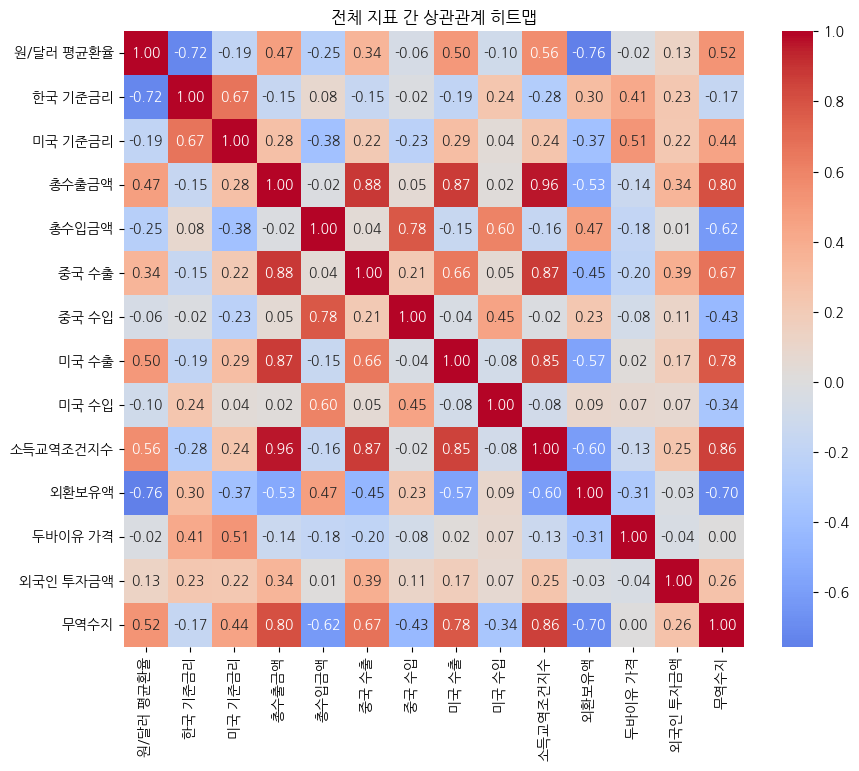

In [32]:
# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("전체 지표 간 상관관계 히트맵")
plt.show()

### 시차 상관 관계 분석

영향이 바로바로 나타날 수는 없음

① 한국 기준금리 → 원/달러 환율<br>

    💡 이유: 금리를 올리면 외국 자본이 들어와서 원화가 강세(환율 하락) 될 수 있음.

    ⏱️ 예상 반응: 1~2개월 뒤

② 미국 기준금리 → 원/달러 환율<br>

    💡 이유: 미국이 금리를 올리면 달러 강세, 원화 약세(환율 상승)

    ⏱️ 예상 반응: 0~1개월

③ 소득교역조건지수 → 원/달러 환율<br>

    💡 이유: 수출 여건이 좋아지면 원화 가치가 높아질 가능성 (환율 하락)

    ⏱️ 예상 반응: 1~3개월

④ 외국인 투자금액 → 원/달러 환율<br>

    💡 이유: 외화 유입으로 원화 강세 (환율 하락)

    ⏱️ 예상 반응: 2~3개월 후

⑤ 국제유가(두바이유) → 원/달러 환율<br>

    💡 이유: 유가 상승 시 에너지 수입 증가 → 무역수지 악화 → 환율 상승

    ⏱️ 예상 반응: 1~2개월 후

#### 1. 한국 & 미국 금리

        한국 기준금리와 환율 상관  미국 기준금리와 환율 상관
시차(개월)                                
0            -0.809944       -0.399119
1            -0.838526       -0.447009
2            -0.816777       -0.413308
3            -0.700368       -0.289736


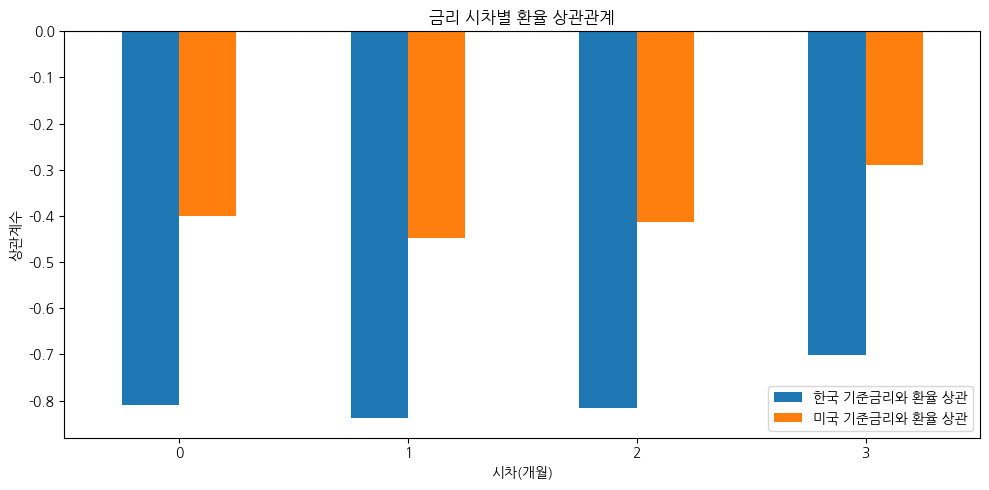

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 결과 저장용 딕셔너리
lag_corrs_kor = {}
lag_corrs_us = {}

# 최대 3개월 시차까지
for lag in range(0, 4):
    # 시차 생성
    df_lagged = df_merged.copy()
    df_lagged[f'한국기준금리_lag{lag}'] = df_lagged['한국 기준금리'].shift(lag)
    df_lagged[f'미국기준금리_lag{lag}'] = df_lagged['미국 기준금리'].shift(lag)

    # 상관계수 계산
    corr_kor = df_lagged[['원/달러 평균환율', f'한국기준금리_lag{lag}']].corr().iloc[0, 1]
    corr_us = df_lagged[['원/달러 평균환율', f'미국기준금리_lag{lag}']].corr().iloc[0, 1]

    # 저장
    lag_corrs_kor[lag] = corr_kor
    lag_corrs_us[lag] = corr_us

# DataFrame으로 정리
df_lag_corr = pd.DataFrame({
    '시차(개월)': list(lag_corrs_kor.keys()),
    '한국 기준금리와 환율 상관': list(lag_corrs_kor.values()),
    '미국 기준금리와 환율 상관': list(lag_corrs_us.values())
})
df_lag_corr.set_index('시차(개월)', inplace=True)
print(df_lag_corr)

# 시각화
df_lag_corr.plot(kind='bar', figsize=(10,5), title="금리 시차별 환율 상관관계")
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("상관계수")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- 가장 상관관계가 높은 시차는 1개월

- 특히 한국 기준금리 1개월 후가 환율과 가장 강한 음의 상관관계를 보임

→ 금리가 오르면 1달 뒤 환율이 내려간다 → 원화 강세 유도 효과

#### 2. 외국인 투자

: 사실 분기별 데이터이지만 선형적으로 채워넣은 데이터이므로 왜곡방지를 위하여 기존 데이터 분기만 보겠음.

In [36]:
# 환율과 외국인 투자 데이터를 분기로 맞추기
df_quarter = df_merged[['원/달러 평균환율', '외국인 투자금액']].resample("QE").mean()

# 시차 0, 1만 확인
for lag in [0, 1]:
    df_quarter[f'외국인투자_lag{lag}'] = df_quarter['외국인 투자금액'].shift(lag)
    corr = df_quarter[['원/달러 평균환율', f'외국인투자_lag{lag}']].corr().iloc[0, 1]
    print(f"{lag}분기 시차 상관계수:", corr)

0분기 시차 상관계수: -0.2561819357328048
1분기 시차 상관계수: 0.12993205704866548


|시차(분기)	|상관계수	|해석|
|---------|-------|--------|
|0	|-0.256	|같은 분기에서 외국인 투자가 많으면 **환율은 살짝 하락(원화 강세)**하는 경향|
|1	|+0.130	|이전 분기 외국인 투자가 많았는데, 그 다음 분기 환율이 올라감(원화 약세) 경향|

- lag = 0
  
  같은 분기 내 외국인 투자 증가 → 원화 수요 증가 → 환율 하락 (✔ 일반적인 경제 흐름과 부합)

- lag = 1

  외국인 투자가 증가한 다음 분기에는 오히려 환율이 올라감

  → 일반적인 예측과 어긋나는 흐름<br>
    (외국인 투자 이후의 다른 요인들이 더 강하게 작용했을 가능성)


    ∴ 외국인 투자는 늘었지만, 그 다음 분기에 금리 인하, 수출 부진, 유가 상승 등이 함께 일어나면 환율은 올라갈 수도



**기본 상관분석과 시차 상관 분석**

- 기본 상관분석

  “같은 시점에서 얼마나 같이 움직이는가?”만 보는 단순 상관관계
      ex ) df_merged.corr()['원/달러 평균환율']['외국인 투자금액']

- 시차 분석

  "과거의 외국인 투자"가 "미래의 환율"에 시간을 두고 영향을 미치는지 확인
      ex) df['외국인 투자금액'].shift(1)
      lag=1은 2023Q1의 외국인 투자금액이 2023Q2 환율에 어떤 영향을 줬는지
     

► 느낀 점 : 단일 변수 상관관계 분석은 한계가 있음

- 왜?

  경제는 다변량 시스템으로 환율은 단순히 금리나 외국인 투자 하나에만 의존하지 않음.

  보통은 여러 변수의 상호작용과 종합적 흐름에 따라 결정.

#### 3. 무역수지(수출-수입)

In [37]:
# 월별 시차 분석 (분기 resample 없이)
df_temp = df_merged[['원/달러 평균환율', '무역수지']].copy()

for lag in range(0, 4):  # 최대 3개월 시차까지
    df_temp[f'무역수지_lag{lag}'] = df_temp['무역수지'].shift(lag)
    corr = df_temp[['원/달러 평균환율', f'무역수지_lag{lag}']].corr().iloc[0, 1]
    print(f"{lag}개월 시차 상관계수: {corr}")

0개월 시차 상관계수: 0.5199707187742776
1개월 시차 상관계수: 0.5160132538444014
2개월 시차 상관계수: 0.43156735582960176
3개월 시차 상관계수: 0.5076001199671382


**결과**

: 이번 달 무역수지 흑자일수록 → 환율 상승 (원화 약세) 경향

  일반적 기대는 **무역수지 흑자 → 원화 강세 → 환율 하락 (음의 상관)**인데,

  결과는 양의 상관관계 → 조금 반대 방향이 나타남

<br>

**왜 그럴까**

① 환율 영향 요인이 무역수지만 있는 게 아님

- 같은 시기에 외국인 자금 유출, 금리 변화, 유가 급등 등이 있다면, 무역수지 효과가 상쇄될 수 있음

② 수출 증가 = 달러 벌이 증가, 그런데 이를 바로 원화로 환전하지 않을 수도 있음
- 기업들이 외화 자산으로 보유하면서 시장에 달러 공급 안 하면 → 환율 오히려 상승

#### 4. 소득교역조건지수(B)

In [38]:
# 월별 시차 상관분석: 소득교역조건지수(B)
df_temp = df_merged[['원/달러 평균환율', '소득교역조건지수']].copy()

for lag in range(0, 4):  # 0~3개월 시차
    df_temp[f'소득교역_lag{lag}'] = df_temp['소득교역조건지수'].shift(lag)
    corr = df_temp[['원/달러 평균환율', f'소득교역_lag{lag}']].corr().iloc[0, 1]
    print(f"{lag}개월 시차 상관계수: {corr}")

0개월 시차 상관계수: 0.5104902599364214
1개월 시차 상관계수: 0.5320174633167981
2개월 시차 상관계수: 0.5142808096499565
3개월 시차 상관계수: 0.675885441335961


##### 4-1. 소득교역지수(B)와 무역수지, 수출금액의 상관분석

소득교역조건지수 = (수출단가 / 수입단가) × 수출물량지수

수출이 많아지고 수입보다 많아지면 → 무역수지 흑자 → 역시 B지수도 높아짐

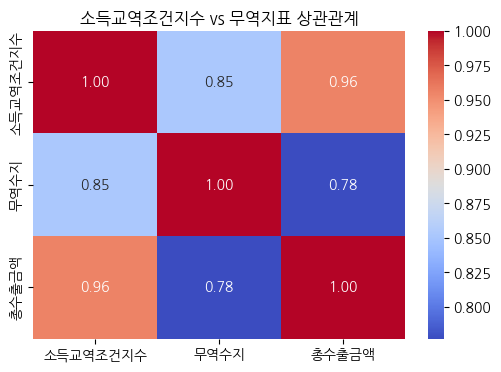

In [39]:
# 필요한 변수만 추출
df_corr = df_merged[['소득교역조건지수', '무역수지', '총수출금액']].dropna()

# 상관관계 분석
corr_matrix = df_corr.corr()

# 결과 출력
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("소득교역조건지수 vs 무역지표 상관관계")
plt.show()

##### 4-5. 미국/중국 수출과 소득교역조건지수의 관계

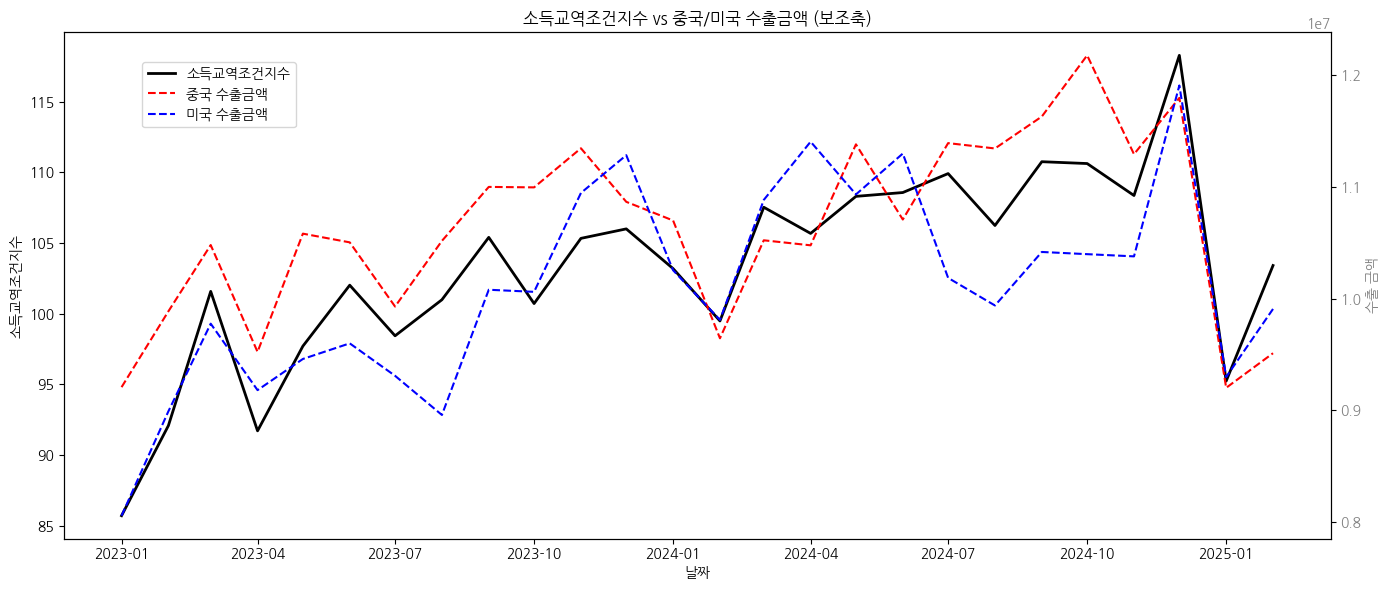

In [44]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# 첫 번째 y축 (소득교역조건지수)
ax1.set_xlabel('날짜')
ax1.set_ylabel('소득교역조건지수', color='black')
ax1.plot(df_merged.index, df_merged['소득교역조건지수'], color='black', label='소득교역조건지수', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')

# 두 번째 y축 (수출금액들)
ax2 = ax1.twinx()
ax2.set_ylabel('수출 금액', color='gray')
ax2.plot(df_merged.index, df_merged['중국 수출'], label='중국 수출금액', linestyle='--', color='red')
ax2.plot(df_merged.index, df_merged['미국 수출'], label='미국 수출금액', linestyle='--', color='blue')
ax2.tick_params(axis='y', labelcolor='gray')

# 범례 정리
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.title('소득교역조건지수 vs 중국/미국 수출금액 (보조축)')
plt.tight_layout()
plt.show()

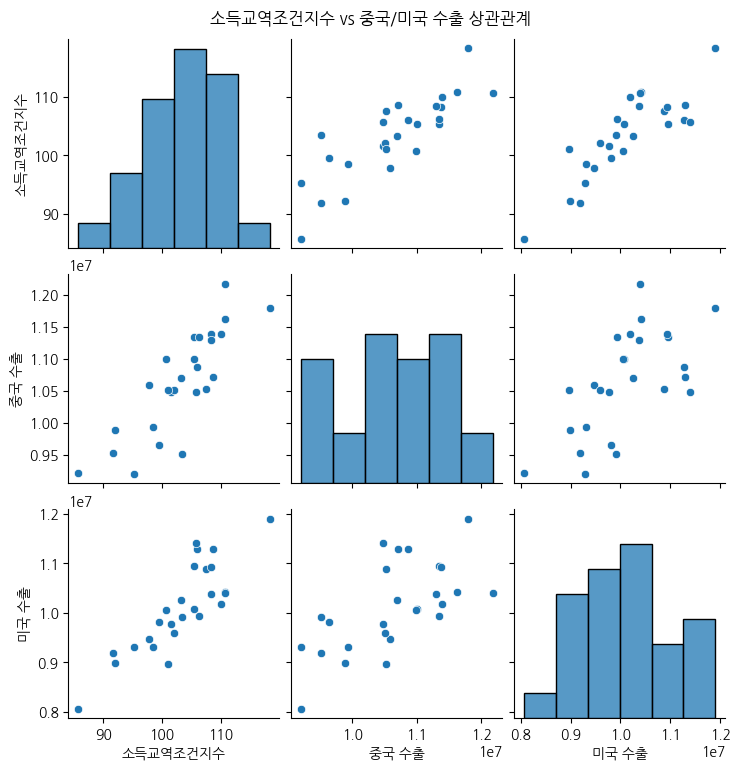

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

df_temp = df_merged[['소득교역조건지수', '중국 수출', '미국 수출']].dropna()

sns.pairplot(df_temp)
plt.suptitle('소득교역조건지수 vs 중국/미국 수출 상관관계', y=1.02)
plt.show()


|분석 대상	|상관관계 강도	|해석 요약|
|-------|---------------|-----------|
|소득교역지수 ↔ 중국 수출|	 강함	|우상향 뚜렷|
|소득교역지수 ↔ 미국 수출|	보통 이상|	경향은 있지만 조금 더 퍼짐|
|중국 ↔ 미국 수출	|약함	|서로 영향은 크지 않음|

In [45]:
# 상관계수 보기
cols = ['소득교역조건지수', '중국 수출', '미국 수출']
corr_matrix = df_merged[cols].corr()

corr_matrix

,소득교역조건지수,중국 수출,미국 수출
소득교역조건지수,1.000000,0.832526,0.851903
중국 수출,0.832526,1.000000,0.641163
미국 수출,0.851903,0.641163,1.000000


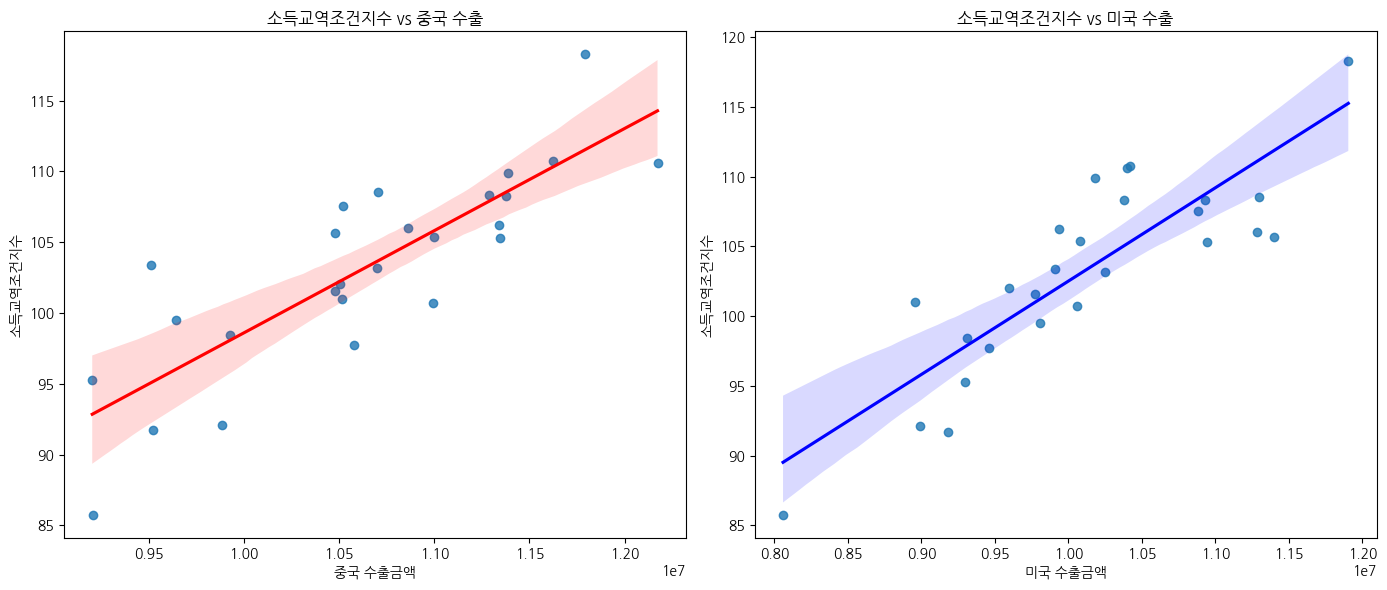

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정 (가로 2개의 subplot 생성)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 소득교역조건지수 vs 중국 수출
sns.regplot(
    data=df_merged, x='중국 수출', y='소득교역조건지수',
    ax=axes[0], line_kws={'color': 'red'}
)
axes[0].set_title('소득교역조건지수 vs 중국 수출')
axes[0].set_xlabel('중국 수출금액')
axes[0].set_ylabel('소득교역조건지수')

# 2. 소득교역조건지수 vs 미국 수출
sns.regplot(
    data=df_merged, x='미국 수출', y='소득교역조건지수',
    ax=axes[1], line_kws={'color': 'blue'}
)
axes[1].set_title('소득교역조건지수 vs 미국 수출')
axes[1].set_xlabel('미국 수출금액')
axes[1].set_ylabel('소득교역조건지수')

plt.tight_layout()
plt.show()

#### 5. 총 수출/수입금액

In [48]:
def lag_correlation_analysis(variable_name):
    print(f"\n{variable_name} vs 원/달러 평균환율 시차 상관계수")
    for lag in range(4):  # 0~3개월
        corr = df_merged["원/달러 평균환율"].corr(df_merged[variable_name].shift(lag))
        print(f"{lag}개월 시차 상관계수: {corr}")

# 총수출금액 시차 분석
lag_correlation_analysis("총수출금액")

# 총수입금액 시차 분석
lag_correlation_analysis("총수입금액")



총수출금액 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: 0.37918508130706324
1개월 시차 상관계수: 0.3657539863933905
2개월 시차 상관계수: 0.40111488101091886
3개월 시차 상관계수: 0.6179479750134612

총수입금액 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: -0.3504653886159479
1개월 시차 상관계수: -0.3610092076152173
2개월 시차 상관계수: -0.19255938806369308
3개월 시차 상관계수: -0.06612199960360865


- 수출 : 3개월	+0.618	강한 양의 상관관계 → 시차 3개월 시점에서 영향 가능성 큼<br>
    수출금액이 많아진 뒤 3개월 정도 지나서 환율이 상승하는 경향이 있다는 해석 가능. (자본 유출 가능성)

- 수입 : 수입금액은 환율과 반대 방향으로 움직이지만, 3개월로 갈수록 영향력이 희미. <br>
→ 시차 1개월 정도가 가장 의미 있는 것 같음.



##### 6. 외화보유액

외환보유액은 보통 외환시장 개입, 시장 안정성 확보 수단이기 때문에

원화가 약세일수록 많이 쓰이고, 강세일수록 축적되는 경향도 있을 수 있음.

In [49]:
for lag in range(4):
    corr = df_merged['원/달러 평균환율'].corr(df_merged['외환보유액'].shift(lag))
    print(f"{lag}개월 시차 상관계수: {corr}")

0개월 시차 상관계수: -0.8058265395905644
1개월 시차 상관계수: -0.6281141073722455
2개월 시차 상관계수: -0.48021025479662843
3개월 시차 상관계수: -0.3916941817969262


**결과**

- 즉시(0개월 시차) 반응이 가장 강함

  : 외환보유액이 많을수록 환율(원/달러)은 낮아진다 → 원화 가치 상승

 ↳ 한국은행이 외환을 많이 보유하고 있을수록 시장 안정성이 크고, 투기 방어 여력도 있어서 환율이 하락함.

- 시차가 늘어날수록 영향은 점차 줄어듦 → 구조적이고 단기 반응 중심인 지표로 해석

##### 7. 두바이유

In [50]:
for lag in range(4):
    corr = df_merged['원/달러 평균환율'].corr(df_merged['두바이유 가격'].shift(lag))
    print(f"{lag}개월 시차 상관계수: {corr}")

0개월 시차 상관계수: -0.20164740262456965
1개월 시차 상관계수: -0.19326766464209724
2개월 시차 상관계수: -0.3159955515303613
3개월 시차 상관계수: -0.44458020159807227


**결과**

  두바이유는 시차 3개월에서 가장 큰 영향을 보임.

  그러나 상관계수 자체는 -0.44로 보통 정도이고, 해석은 복합적 맥락 고려 필요.

  다중 회귀 분석에 넣을 수는 있지만, 단독 변수로는 영향이 불분명할 수 있음.

<br>


**왜 강한 상관관계가 보이지 않을까?**

  유가 상승기엔 수출도 같이 호조를 보이면서 환율 방어가 되었을 가능성

  두바이유의 가격이 글로벌 위험 회피 심리랑 반대로 움직인 결과? (유가 상승기 = 경기회복 기대감 → 달러 약세 → 원화 강세)


##### 8. 미국/중국 수출입

In [51]:
def lag_corr_by_var(var_name):
    print(f"\n{var_name} vs 원/달러 평균환율 시차 상관계수")
    for lag in range(4):
        corr = df_merged["원/달러 평균환율"].corr(df_merged[var_name].shift(lag))
        print(f"{lag}개월 시차 상관계수: {corr:.4f}")

# 중국 수출/수입
lag_corr_by_var("중국 수출")
lag_corr_by_var("중국 수입")

#미국 수출/수입
lag_corr_by_var("미국 수출")
lag_corr_by_var("미국 수입")



중국 수출 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: 0.1840
1개월 시차 상관계수: 0.1733
2개월 시차 상관계수: 0.3227
3개월 시차 상관계수: 0.6328

중국 수입 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: -0.2437
1개월 시차 상관계수: -0.3006
2개월 시차 상관계수: -0.1349
3개월 시차 상관계수: -0.0390

미국 수출 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: 0.4420
1개월 시차 상관계수: 0.4480
2개월 시차 상관계수: 0.3943
3개월 시차 상관계수: 0.4869

미국 수입 vs 원/달러 평균환율 시차 상관계수
0개월 시차 상관계수: -0.1186
1개월 시차 상관계수: -0.2642
2개월 시차 상관계수: -0.2332
3개월 시차 상관계수: -0.1154


|변수|	시차(3개월)|	상관계수	|해석|
|--------|-------|----|----------|
|🇨🇳 중국 수출|	+3개월|	+0.633	|강한 양의 상관관계 (수출 많을수록 환율↑, 원화↓)|
|🇨🇳 중국 수입	|+3개월	|-0.039	|거의 무관|
|🇺🇸 미국 수출	|+3개월	|+0.487	|중간~강한 양의 상관|
|🇺🇸 미국 수입	|+3개월	|-0.115	|약한 음의 상관|
|📈 소득교역조건지수(B)	|+3개월	|+0.676	|강한 양의 상관관계|

### 미국과 중국의 수입/수출, 총 수입/수출(미중 포함) 다중공선성 문제 유발가능


In [55]:
df_merged.columns

Index(['원/달러 평균환율', '한국 기준금리', '미국 기준금리', '총수출금액', '총수입금액', '중국 수출', '중국 수입',
       '미국 수출', '미국 수입', '소득교역조건지수', '외환보유액', '두바이유 가격', '외국인 투자금액', '무역수지',
       '기타 수출', '기타 수입'],
      dtype='object')

In [54]:
# 미국/중국 제외 수출 수입 계산
df_merged["기타 수출"] = df_merged["총수출금액"] - (df_merged["미국 수출"] + df_merged["중국 수출"])
df_merged["기타 수입"] = df_merged["총수입금액"] - (df_merged["미국 수입"] + df_merged["중국 수입"])

In [57]:
df_merged[['원/달러 평균환율', '기타 수출', '기타 수입']].corr()

,원/달러 평균환율,기타 수출,기타 수입
원/달러 평균환율,1.000000,0.381964,-0.372621
기타 수출,0.381964,1.000000,0.005137
기타 수입,-0.372621,0.005137,1.000000


In [58]:
for lag in range(4):
    corr = df_merged['기타 수출'].shift(lag).corr(df_merged['원/달러 평균환율'])
    print(f"{lag}개월 시차 상관계수 (기타 수출): {corr:.4f}")

0개월 시차 상관계수 (기타 수출): 0.3820
1개월 시차 상관계수 (기타 수출): 0.3609
2개월 시차 상관계수 (기타 수출): 0.3873
3개월 시차 상관계수 (기타 수출): 0.5956


In [59]:
for lag in range(4):
    corr = df_merged['기타 수입'].shift(lag).corr(df_merged['원/달러 평균환율'])
    print(f"{lag}개월 시차 상관계수 (기타 수입): {corr:.4f}")

0개월 시차 상관계수 (기타 수입): -0.3726
1개월 시차 상관계수 (기타 수입): -0.3136
2개월 시차 상관계수 (기타 수입): -0.1467
3개월 시차 상관계수 (기타 수입): -0.0415


## 시차 변수 채택 목록 (환율 예측용) - 기존 상관 vs 시차 상관 비교

| 변수                     | 기존 상관계수 | 최적 시차 | 시차 상관계수 | 상관 방향 | 비고 |
|--------------------------|----------------|-----------|----------------|------------|------|
| 🇰🇷 한국 기준금리          | -0.8099         | 1개월      | **-0.8385**     | 음의 상관  | 매우 강한 영향 |
| 🇺🇸 미국 기준금리          | -0.3991         | 1개월      | -0.4470         | 음의 상관  | 약한 음의 영향 |
| 💰 외국인 투자금액         | 0.1291          | 1분기      | 0.1299          | 양의 상관  | 영향 미약 (주의) |
| 📈 무역수지               | 0.5199          | 0개월      | **0.5199**      | 양의 상관  | 높은 상관 |
| 📈 소득교역조건지수        | 0.5105          | 3개월      | **0.6759**      | 양의 상관  | 지연된 영향 큼 |
| 📤 총 수출금액             | 0.3792          | 3개월      | **0.6179**      | 양의 상관  | 직접적인 영향 추정 |
| 📥 총 수입금액             | -0.3505         | 0개월      | -0.3505         | 음의 상관  | 즉각적 영향 |
| 🌍 외환보유액              | -0.8058         | 0개월      | **-0.8058**     | 음의 상관  | 매우 강한 영향 |
| 🛢️ 두바이유 가격           | -0.2016         | 3개월      | -0.4446         | 음의 상관  | 점진적 영향 추정 |
| 🇨🇳 중국 수출금액           | 0.1840          | 3개월      | **0.6328**      | 양의 상관  | 높은 시차 상관 |
| 🇨🇳 중국 수입금액           | -0.2437         | 1개월      | -0.3006         | 음의 상관  | 미약한 영향 |
| 🇺🇸 미국 수출금액           | 0.4420          | 3개월      | 0.4869          | 양의 상관  | 적당한 영향 |
| 🇺🇸 미국 수입금액           | -0.1186         | 1개월      | -0.2642         | 음의 상관  | 영향은 약함 |
| 📦 기타 수출금액           | 0.3820          | 3개월      | **0.5956**      | 양의 상관  | 중국·미국 외 영향 있음 |


## 시차 변수 채택 목록 (환율 예측용)(기존과 같은건 제외) - 기존 상관 vs 시차 상관 비교

| 변수                     | 기존 상관계수 | 최적 시차 | 시차 상관계수 | 상관 방향 | 비고 |
|--------------------------|----------------|-----------|----------------|------------|------|
| 🇰🇷 한국 기준금리          | -0.8099         | 1개월      | **-0.8385**     | 음의 상관  | 매우 강한 영향 |
| 🇺🇸 미국 기준금리          | -0.3991         | 1개월      | -0.4470         | 음의 상관  | 약한 음의 영향 |
| 💰 외국인 투자금액         | 0.1291          | 1분기      | 0.1299          | 양의 상관  | 영향 미약 (주의) |
| 📈 소득교역조건지수        | 0.5105          | 3개월      | **0.6759**      | 양의 상관  | 지연된 영향 큼 |
| 📤 총 수출금액             | 0.3792          | 3개월      | **0.6179**      | 양의 상관  | 직접적인 영향 추정 |
| 🛢️ 두바이유 가격           | -0.2016         | 3개월      | -0.4446         | 음의 상관  | 점진적 영향 추정 |
| 🇨🇳 중국 수출금액           | 0.1840          | 3개월      | **0.6328**      | 양의 상관  | 높은 시차 상관 |
| 🇨🇳 중국 수입금액           | -0.2437         | 1개월      | -0.3006         | 음의 상관  | 미약한 영향 |
| 🇺🇸 미국 수출금액           | 0.4420          | 3개월      | 0.4869          | 양의 상관  | 적당한 영향 |
| 🇺🇸 미국 수입금액           | -0.1186         | 1개월      | -0.2642         | 음의 상관  | 영향은 약함 |
| 📦 기타 수출금액           | 0.3820          | 3개월      | **0.5956**      | 양의 상관  | 중국·미국 외 영향 있음 |


### 시차 변수의 필요성?

|이유	|설명|
|----|------|
|정책·금리 변화의 전달 시간	|한국은행이 기준금리를 올려도, 그 효과가 시장에 퍼지기까지는 시간이 걸림. 기업의 대출비용 → 소비자 지출 → 수입·수출 → 환율… 이런 전이 과정이 존재.|
|투자 판단 지연	|외국인 투자자들도 정책 변화, 금리, 국제정세 등 여러 요인을 종합 판단한 뒤, 시간이 지난 뒤 자산 이동|
|거래 시차|	수출 계약이 체결되고, 실제 거래·환전이 일어나기까지 수 주~수 개월이 걸리는 경우 많음.|